# Stats lab Tworek and Cimpian 2016 Study 1 lLnear regression analyis.
# The data can be downloaded from  https://drive.google.com/file/d/0Bz-rhZ21ShvOTl9wdHBQdG1YSDQ/view

# STUDY DESCRIPTION


 The ability to reason about cause and effect is a fundamental human trait. Yet, people rarely think about all of the possible causes for a particular effect, and instead rely on heuristic explanations that seemplausible. Such biases may be present for how individuals explain the status quo. When people thinkabout why something “is,” they may assume that there is an inherent property of the thing that causes itto be so. For example, imagine Susan is thinking about why she is best friends with Allison. Susan may believe that she and Allison are “meant” to be friends because they have inherent traits (e.g., similarsenses of humor) that lead them to be compatible. Susan may believe this cause to be a plausibleexplanation for her friendship with Allison, even though another reason that they are friends is that they were randomly assigned to be suitemates during their freshman year at college.People’s tendency to confuse what ‘is’ with what ‘ought to be’ is the focus of research by Tworek andCimpian (2016). These researchers wanted to determine whether individuals tendency to explain eventsbased on their inherent properties (i.e., inherence bias) would predict the extent to which they viewtypical outcomes as good and desirable.

 To study this, the researchers recruited 122 individuals from an online participant pool. The participants first read six articles that explained a status quo societal practice (e.g., Americans eat a lot of pizza). Afterreading each article, participants responded to various questions assessing the extent to which the status quo ought to occur (e.g., Americans eat a lot of pizza because pizza is delicious). These questions measured participants tendency to make Ought inferences. Next, participants responded to 15 items designed to measure their level of inherence bias (i.e., their tendency to explain events based on inherent properties). Participants also completed various additional measures, including a measure of intelligence

(Raven’s Progressive Matrix), belief in a just world, political views (Conservatism), and demographics (education). For more details, see the Tworek and Cimpian (2016) Study 1 method section.

In [7]:
%matplotlib inline
import pystan as ps
import numpy as np
import pandas as pd
import seaborn
import arviz as az
import matplotlib.pyplot as plt
import os

In [8]:
os.chdir(r"C:\Users\harri\OneDrive\Documents\Stats 2")

df = pd.read_csv("Tworek and Cimpian 2016 Study 1.csv")

df.head()

,excluded,RavensProgressiveMatrix_sum,Inherence_Bias,Should_Score,Good_Score,Ought_Score,Belief_in_Just_World,instructionsâ onthefollowingscreensyouwillbeaskedtofilloutseve,startnextsurvey,pleasereadthestatementsonthefollowingpages.thinkcarefullyaboutho,...,age,conserv,english,thankyouforparticipating.pleaseanswerthefollowingfewquestionstoh,@1.didyoufindanyaspectoftheprocedureoddorconfusing,@2.whatdidyouthinkwewerestudying,@3.doyouthinkthattheremayhavebeenmoretothisstudythanmeetstheeyei,@4.doyouhaveanyadditionalthoughtsorcommentsaboutthestudy,attention,filter_$
0,0,5,7.666667,6.333333,6.666667,6.500000,5.65,1,1,1,...,26,7,1,1,no,unsure,yes but unsure what,no,1,1
1,1,5,7.333333,6.666667,8.000000,7.333333,4.60,1,1,1,...,28,3,1,1,not at all; it was very enlightening,opinions across different demographics,i dont believe so,none at all,1,0
2,0,4,5.333333,5.666667,2.666667,4.166667,4.20,1,1,1,...,35,6,1,1,No,Patience for answering narrative questions aft...,No.,No,1,1
3,0,2,5.800000,8.000000,7.666667,7.833333,4.85,1,1,1,...,48,7,1,1,Not really. The surveys were nothing alike.,I dont know. Americas habits and buying trends...,No it was kinda odd that the parts were so dif...,No,1,1
4,0,2,4.266667,7.000000,3.666667,5.333333,4.65,1,1,1,...,45,5,1,1,Not really.,Not sure.,"Yes, but not sure what.",Nope,1,1


In [17]:
#The paper identified american participants coded 0 in filter_$ coloumn
#coded as 0 and removed below by extracting all values in that column of 1
#into new dataframe.

filtered = df[df["filter_$"] == 1]

Ought = filtered["Ought_Score"].to_numpy()

Inherence_Bias = filtered["Inherence_Bias"].to_numpy() 



In [18]:
#Check for NA/missing data for Ought scores
filtered["Ought_Score"].isnull()

0      False
2      False
3      False
4      False
5      False
       ...  
126    False
127    False
128    False
129    False
130    False
Name: Inherence_Bias, Length: 122, dtype: bool

In [19]:
#Check for NA/missing data for Ought scores
filtered["Inherence_Bias"].isnull()

0      False
2      False
3      False
4      False
5      False
       ...  
126    False
127    False
128    False
129    False
130    False
Name: Inherence_Bias, Length: 122, dtype: bool

# Regression model apecified below

# $$y \sim \alpha + \beta_{1}X$$
# $$ \sigma \sim(0, \infty) $$ $$ \alpha \sim(0, \infty) $$ $$ \beta_{1} \sim(0, 1) $$

In [10]:
# Stan regression model coded into string to be called for C++ compilation and HMC 
# sampling of the posterior distribution below

Stats_labSR= """ 
data {
  int<lower=0> N; //interger lower bound of z
  vector[N] x; // specifying vector length of N
  vector[N] y; // specifying vector length of N
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  beta ~ normal(0, 1); // example of informative priors
  y ~ normal(alpha + beta * x, sigma);
}

"""

In [11]:
# Python dictionary of data values for calling to Stan and model fitting
Stats_labSR_data = {"N": len(Ought),
                   "y": Ought,
                   "x": Inherence_Bias}

# Fit and sample model
SR_fit = ps.stan(model_code = Stats_labSR, data = Stats_labSR_data, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cebae3fcd7fa8e958df921ac322334c9 NOW.


In [12]:
print(SR_fit)

Inference for Stan model: anon_model_cebae3fcd7fa8e958df921ac322334c9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.92  6.4e-3   0.52    2.9   3.58   3.92   4.26   4.94   6510    1.0
beta     0.3  1.1e-3   0.09   0.13   0.24    0.3   0.35   0.46   6539    1.0
sigma   1.08  7.5e-4   0.07   0.95   1.03   1.08   1.13   1.23   8969    1.0
lp__  -69.83    0.02   1.23 -73.04 -70.39 -69.51 -68.92 -68.42   6547    1.0

Samples were drawn using NUTS at Mon Nov  2 07:35:19 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Plotting posterior distributions.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000298E927AB08>,
      dtype=object)

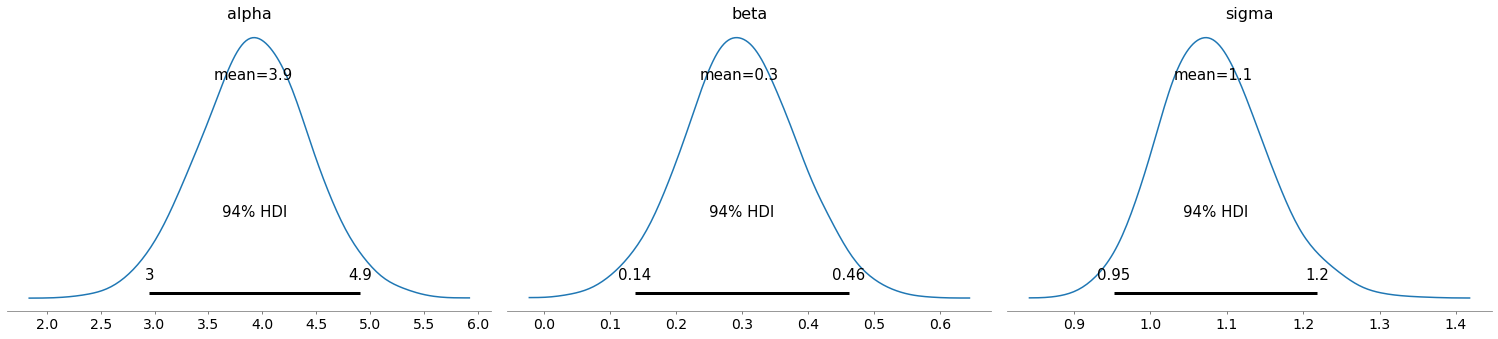

In [14]:
az.plot_posterior(SR_fit)

# Trace plot belows showing the chains mixing well for all parameter estimate reflecting Rhat values = 1 above.

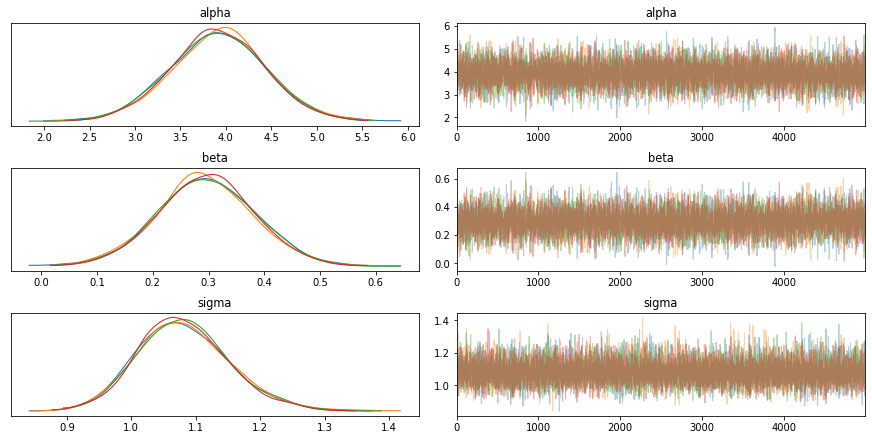

In [15]:
az.plot_trace(SR_fit);

# Find away to plot regression findings in the standard way but witht these